In [6]:
 # Mounting Drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
from pathlib import Path
from textwrap import fill

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tiktoken
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [3]:
LLM_SERVER = "http://localhost:11434"
MODEL = "gemma3:1b"
DATA_DIR = Path.cwd().parent / "data"

In [8]:
# Importing data
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Document_Summarization_LLM/train.csv')
df_train

,paper_id,text,summary
0,0,## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCI...,"In this article, Victor Fan argues that analys..."
1,1,## 1. Introduction\n\n\nAn Electronic Health R...,Problem definition: Physicians spend more than...
2,2,## Introduction\n\n\nTranslation plays an i...,Literary translation is one of the most challe...
3,3,## 1 Problem Setup\n\n\nRecent political scien...,There is a long-running debate on evaluating f...
4,4,## INTRODUCTION\n\n\nThis article investigat...,"Recently, ‘bimajyo’ (美魔女) came into focus in J..."
...,...,...,...
995,995,## Methods\n\n\n\n## Sample\n\n\nOur data come...,Demand for democratic accountability in polici...
996,996,## Introduction\n\n\nCanada is a high-income c...,Canada’s employment standards laws and mandato...
997,997,## Introduction\n\n\nCultural studies has ofte...,Cultural studies has often favoured a Foucauld...
998,998,## 1. Introduction\n\n\nTwentieth century plan...,Vehicular air pollution has created an ongoing...


In [11]:
print(f"Document length: {len(df_train.loc[0, 'text']):,} characters")
print("Document:")
print(fill(df_train.loc[0, "text"], replace_whitespace=False)[:1000])

Document length: 33,416 characters
Document:
## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCIOUSNESS


Since 1997,
the concept of extraterritoriality has been configured in the
political tension between Hong Kong and Beijing. From the perspective
of the Central Government, it is fundamental for the people of China
to shijian zhuquan instantiate its sovereignty over Hong Kong. But
while most Hong / Kong residents insist on interpreting this concept
in terms of the Euro-American notion of selfdetermination  (zizhu /
making decisions  for  oneself),  the  Beijing  government  believes
that  the Hong Kong legislature must make decisions in conformation to
the larger will of the people, which the Party represents, a concept
taken from the writings of Lenin and Stalin (Gao 2010: 26-30). This
tension is crystalised in the long debate about Article 23 of the Hong
Kong Basic Law, which requires  the  SAR  to  'enact  laws  on  its
own  to  prohibit  any  act  of  treason,  secession,  sedition,
s

In [13]:
print(fill(df_train.loc[0, "summary"]))

In this article, Victor Fan argues that analysing contemporary Hong
Kong cinema requires active rewriting of established postcolonial
theories by taking into account the specific mode of colonisation of
Hong Kong: extraterritoriality. This concept has been responsible for
the construction of the cultural plurality, linguistic ambiguity, and
political liminality of Hong Kong and its cinematographic experience,
as well as the incongruence between the community’s political
consciousness after 1997 and the larger national imagination
promulgated by the Beijing government. The term ‘extraterritoriality’
was translated into Chinese after 1895 via Japanese as zhiwai faquan
the right to exercise one’s law outside a nation state’s sovereign
terrain, and colonialism in China between 1844 and 1949 was largely
characterized by a continuous reformulation and systematisation of
this concept. It in fact still informs the way former colonised
regions in China are administered today, and the political 

In [16]:
df_train["text_len"] = df_train.text.str.len()
df_train["summary_len"] = df_train.summary.str.len()
df_train["text_len_log"] = np.log10(df_train.text_len)
df_train["summary_len_log"] = np.log10(df_train.summary_len)

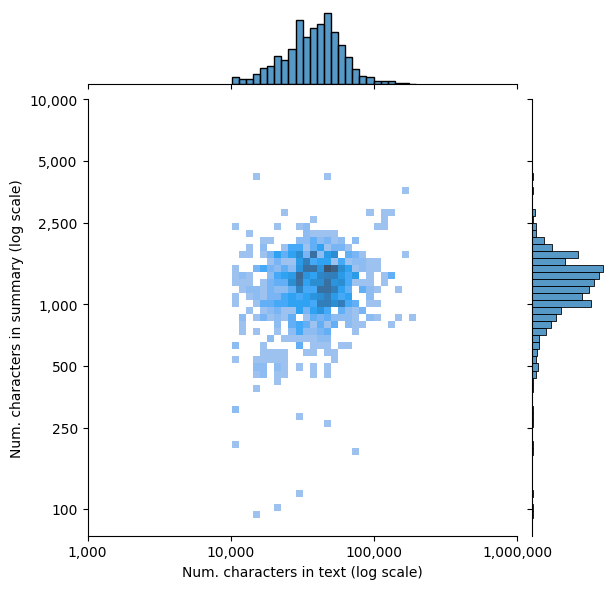

In [18]:
g = sns.jointplot(df_train, x="text_len_log", y="summary_len_log", kind="hist")
xticks = [3, 4, 5, 6]
yticks = [2, np.log10(250), np.log10(500), 3, np.log10(2_500), np.log10(5_000), 4]
g.ax_marg_x.set_xticks(xticks, [f"{10**tick:,.0f}" for tick in xticks])
g.ax_marg_y.set_yticks(yticks, [f"{10**tick:,.0f}" for tick in yticks])
g.set_axis_labels(
    "Num. characters in text (log scale)", "Num. characters in summary (log scale)"
)

In [19]:
df_train.describe()


,paper_id,text_len,summary_len,text_len_log,summary_len_log
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,42050.269000,1275.241000,4.574534,3.079240
std,288.819436,21412.146068,426.262199,0.207977,0.162033
min,0.000000,10145.000000,90.000000,4.006252,1.954243
25%,249.750000,28381.500000,1008.500000,4.453035,3.003676
50%,499.500000,38962.000000,1258.500000,4.590641,3.099853
75%,749.250000,51263.250000,1501.250000,4.709806,3.176453
max,999.000000,196911.000000,4359.000000,5.294270,3.639387
